## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Inserimento Dati

http://cocodataset.org

In [5]:
import coco

In [6]:
 coco.set_data_dir("D:/Tesi/img/")


Scarica ed estrai automaticamente i file di dati se non li hai già.

**AVVERTIMENTO! Questi file di dati sono MOLTO grandi! Il file per i dati di addestramento è di 19 GB e il file per i dati di convalida è di 816 MB! **

In [7]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


Ottieni i nomi dei file e le didascalie per le immagini nel set di addestramento.

In [8]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: D:/Tesi/img/records_train.pkl


Numero di immagini nel set di addestramento.

In [9]:
num_images_train = len(filenames_train)
num_images_train

118287

Ottieni i nomi dei file e le didascalie per le immagini nel set di convalida.

In [10]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: D:/Tesi/img/records_val.pkl



### Funzioni di supporto per il caricamento e la visualizzazione delle immagini

Questa è una funzione di supporto per caricare e ridimensionare un'immagine.

In [11]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img


Questa è una funzione di supporto per mostrare un'immagine dal set di dati insieme alle sue didascalie.

In [12]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()


### Immagine di esempio

Mostra un'immagine di esempio e didascalie dal set di addestramento.

A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


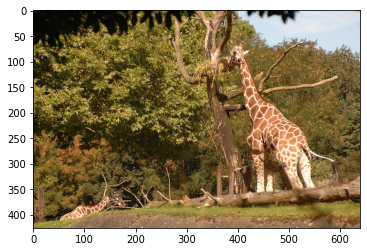

In [13]:
show_image(idx=1, train=True)

## Modello immagine pre-addestrato (VGG16)

Quanto segue crea un'istanza del modello VGG16 utilizzando l'API di Keras. Questo scarica automaticamente i file richiesti se non li hai già.

Il modello VGG16 è stato pre-addestrato sul set di dati ImageNet per la classificazione delle immagini. Il modello VGG16 contiene una parte convoluzionale e una parte completamente connessa (o densa) che viene utilizzata per la classificazione dell'immagine.

Se "include_top = True" viene scaricato l'intero modello VGG16 che è di circa 528 MB. Se "include_top = False" viene scaricata solo la parte convoluzionale del modello VGG16 che è di soli 57 MB.

Useremo alcuni dei livelli completamente connessi in questo modello pre-addestrato, quindi dobbiamo scaricare il modello completo, ma se hai una connessione Internet lenta, puoi provare a modificare il codice sottostante per utilizzare il pre- modello addestrato senza i livelli di classificazione.

I tutorial # 08 e # 10 spiegano maggiori dettagli sul Transfer Learning.

In [14]:
image_model = VGG16(include_top=True, weights='imagenet')

Stampa un elenco di tutti i layer nel modello VGG16.

In [15]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Useremo l'output del livello prima del livello di classificazione finale chiamato "fc2". Questo è uno strato completamente connesso (o denso).

In [16]:
transfer_layer = image_model.get_layer('fc2')

Lo chiamiamo "transfer-layer" perché trasferiremo il suo output su un altro modello che crea le didascalie dell'immagine.

Per fare ciò, prima dobbiamo creare un nuovo modello che abbia lo stesso input del modello VGG16 originale ma che restituisca i valori di trasferimento dal livello `fc2`.

In [17]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

Il modello si aspetta che le immagini di input siano di queste dimensioni:

In [18]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

Per ogni immagine di input, il nuovo modello produrrà un vettore di valori di trasferimento con questa lunghezza:

In [19]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Elabora tutte le immagini

Ora creiamo funzioni per l'elaborazione di tutte le immagini nel set di dati utilizzando il modello di immagine pre-addestrato e salvando i valori di trasferimento in un file di cache in modo che possano essere ricaricati rapidamente.

Creiamo efficacemente un nuovo set di dati dei valori di trasferimento. Questo perché l'elaborazione di un'immagine nel modello VGG16 richiede molto tempo. Non cambieremo tutti i parametri del modello VGG16, quindi ogni volta che elabora un'immagine, fornisce lo stesso identico risultato. Abbiamo bisogno dei valori di trasferimento per addestrare il modello di didascalia delle immagini per molte epoche, quindi risparmiamo molto tempo calcolando i valori di trasferimento una volta e salvandoli in un file di cache.

Questa è una funzione di supporto per la stampa dell'avanzamento.

In [20]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

Questa è la funzione per elaborare i file dati utilizzando il modello VGG16 e restituire i loro valori di trasferimento.

In [21]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Funzione di supporto per l'elaborazione di tutte le immagini nel set di addestramento. Ciò salva i valori di trasferimento in un file di cache per un rapido ricaricamento.

In [22]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

Funzione di supporto per l'elaborazione di tutte le immagini nel set di convalida.

In [23]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

Elabora tutte le immagini nel set di addestramento e salva i valori di trasferimento in un file di cache. Questa operazione ha richiesto circa 30 minuti per l'elaborazione su una GPU GTX 1070.

In [24]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: D:/Tesi/img/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
Wall time: 7.16 s


Elabora tutte le immagini nel set di convalida e salva i valori di trasferimento in un file di cache. Questa operazione ha richiesto circa 90 secondi per l'elaborazione su una GPU GTX 1070.

In [25]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: D:/Tesi/img/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
Wall time: 378 ms


## Tokenizer

Le reti neurali non possono funzionare direttamente sui dati di testo. Utilizziamo un processo in due fasi per convertire il testo in numeri che possono essere utilizzati in una rete neurale. Il primo passo è convertire le parole di testo nei cosiddetti token interi. Il secondo passaggio consiste nel convertire i token interi in vettori di numeri in virgola mobile utilizzando un cosiddetto livello di incorporamento. Vedi Tutorial # 20 per una spiegazione più dettagliata.

Prima di poter iniziare a elaborare il testo, dobbiamo prima contrassegnare l'inizio e la fine di ogni sequenza di testo con parole uniche che molto probabilmente non sono presenti nei dati.

In [26]:
mark_start = 'ssss '
mark_end = ' eeee'

Questa funzione di supporto avvolge tutte le stringhe di testo nei marcatori sopra. Nota che le didascalie sono un elenco di elenchi, quindi abbiamo bisogno di un ciclo for annidato per elaborarlo. Questo può essere fatto usando la cosiddetta comprensione delle liste in Python.

In [27]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

Ora elabora tutte le didascalie nel set di addestramento e mostra un esempio.

In [28]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

Ecco come appaiono le didascalie senza i marcatori di inizio e fine.

In [29]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

This helper-function converts a list-of-list to a flattened list of captions.

In [30]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

Ora usa la funzione per convertire tutte le didascalie contrassegnate dal set di allenamento.

In [31]:
captions_train_flat = flatten(captions_train_marked)

Imposta il numero massimo di parole nel nostro vocabolario. Ciò significa che useremo solo ad es. le 10000 parole più frequenti nelle didascalie dei dati di addestramento.

In [32]:
num_words = 10000

Abbiamo bisogno di alcune funzioni in più rispetto a quelle fornite dalla classe Tokenizer di Keras, quindi lo avvolgiamo.

In [33]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens


Ora crea un tokenizer usando tutte le didascalie nei dati di addestramento. Nota che utilizziamo l'elenco appiattito di didascalie per creare il tokenizer perché non può accettare un elenco di elenchi.

In [34]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

Wall time: 9.84 s


Ottieni il token intero per il marcatore di inizio (la parola "ssss"). Ne avremo bisogno più avanti.

In [35]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

Ottieni il token intero per il marcatore di fine (la parola "eeee").

In [36]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

Converti tutte le didascalie del set di addestramento in sequenze di token interi. Come risultato otteniamo un elenco di elenchi.

In [37]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

Wall time: 8.03 s


Esempio dei token interi per le didascalie della prima immagine nel training-set:

In [38]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

Queste sono le didascalie di testo corrispondenti:

In [39]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

## Generatore di dati

Ogni immagine nel set di formazione ha almeno 5 didascalie che descrivono i contenuti dell'immagine. La rete neurale verrà addestrata con batch di valori di trasferimento per le immagini e sequenze di token interi per le didascalie. Se dovessimo avere array numpy corrispondenti per il set di addestramento, dovremmo usare solo una singola didascalia per ogni immagine e ignorare il resto di questi preziosi dati, oppure dovremmo ripetere i valori di trasferimento dell'immagine per ciascuno di le didascalie, che sprecherebbero molta memoria.

Una soluzione migliore è creare un generatore di dati personalizzato per Keras che creerà un batch di dati con valori di trasferimento e sequenze di token selezionati casualmente.

Questa funzione di supporto restituisce un elenco di sequenze di token casuali per le immagini con gli indici dati nel set di addestramento.

In [40]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

Questa funzione generatore crea batch casuali di dati di addestramento da utilizzare per l'addestramento della rete neurale.

In [41]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

Imposta la dimensione del batch utilizzata durante l'addestramento. Questo è impostato molto alto in modo che la GPU possa essere utilizzata al massimo, ma questo richiede anche molta RAM sulla GPU. Potrebbe essere necessario ridurre questo numero se la memoria si esaurisce.

In [42]:
batch_size = 160

Crea un'istanza del generatore di dati.

In [43]:
generator = batch_generator(batch_size=batch_size)

Prova il generatore di dati creando un batch di dati.

In [44]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

Esempio dei valori di trasferimento per la prima immagine nel batch.

In [45]:
batch_x['transfer_values_input'][0]

array([0.   , 0.   , 1.489, ..., 0.   , 0.   , 0.836], dtype=float16)

Esempio della sequenza di token per la prima immagine nel batch. Questo è l'input per la parte decodificatore della rete neurale.

In [46]:
batch_x['decoder_input'][0]

array([  2,  30, 606, 541, 217,  87,   5,   1, 294,   3,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

Questa è la sequenza di token per l'uscita del decoder. Nota come è la stessa della sequenza sopra, tranne per il fatto che è spostata di un passo temporale.

In [47]:
batch_y['decoder_output'][0]

array([ 30, 606, 541, 217,  87,   5,   1, 294,   3,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

### Passi per epoca

Un'epoca è un'elaborazione completa del set di addestramento. Vorremmo elaborare ogni coppia di immagini e didascalie solo una volta per epoca. Tuttavia, poiché ogni batch viene scelto completamente a caso nel generatore di batch di cui sopra, è possibile che un'immagine si verifichi in più batch all'interno di una singola epoca, ed è possibile che alcune immagini possano non verificarsi affatto in alcun batch all'interno di una singola epoca.

Tuttavia, utilizziamo ancora il concetto di "epoca" per misurare approssimativamente quante iterazioni dei dati di addestramento abbiamo elaborato. Ma il generatore di dati genererà batch per l'eternità, quindi dobbiamo calcolare manualmente il numero approssimativo di batch richiesti per epoca.

Questo è il numero di didascalie per ciascuna immagine nel set di addestramento.

In [48]:
num_captions_train = [len(captions) for captions in captions_train]

Questo è il numero totale di didascalie nel set di addestramento

In [49]:
total_num_captions_train = np.sum(num_captions_train)

Questo è il numero approssimativo di batch richiesti per epoca, se vogliamo elaborare ogni coppia di didascalie e immagini una volta per epoca.

In [50]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

3698


## Crea la rete neurale ricorrente

Creeremo ora la Recurrent Neural Network (RNN) che verrà addestrata a mappare i vettori con valori di trasferimento dal modello di riconoscimento delle immagini in sequenze di token interi che possono essere convertiti in testo. Chiamiamo questa rete neurale per il "decodificatore" poiché è quasi identico al decodificatore quando si esegue la traduzione automatica nel tutorial n. 21.

Si noti che stiamo utilizzando il modello funzionale di Keras per costruire questa rete neurale, perché consente una maggiore flessibilità nel modo in cui la rete neurale può essere collegata, nel caso si desideri sperimentare e connettere il modello immagine direttamente al decoder (vedere gli esercizi ). Ciò significa che abbiamo diviso la costruzione della rete in due parti: (1) creazione di tutti i livelli che non sono ancora connessi e (2) una funzione che collega tutti questi livelli.

Il decoder è composto da 3 strati GRU le cui dimensioni interne dello stato sono:

In [51]:
state_size = 512

Il livello di incorporamento converte i token interi in vettori di questa lunghezza:

In [52]:
embedding_size = 128

Questo immette i valori di trasferimento al decoder:

In [53]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

Vogliamo utilizzare i valori di trasferimento per inizializzare gli stati interni delle unità GRU. Questo informa le unità GRU del contenuto delle immagini. I valori di trasferimento sono vettori di lunghezza 4096 ma le dimensioni degli stati interni delle unità GRU sono solo 512, quindi utilizziamo uno strato completamente connesso per mappare i vettori da 4096 a 512 elementi.

Nota che usiamo una funzione di attivazione `tanh` per limitare l'output della mappatura tra -1 e 1, altrimenti questo non sembra funzionare.

In [54]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

Questo è l'ingresso per le sequenze di token al decoder. Usare "Nessuno" nella forma significa che le sequenze di token possono avere lunghezze arbitrarie.

In [55]:
decoder_input = Input(shape=(None, ), name='decoder_input')

Questo è lo strato di incorporamento che converte le sequenze di token interi in sequenze di vettori.

In [56]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

Questo crea i 3 strati GRU del decoder. Si noti che restituiscono tutte sequenze perché in ultima analisi vogliamo produrre una sequenza di token interi che possono essere convertiti in una sequenza di testo.

In [57]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

I livelli GRU producono un tensore con forma `[batch_size, sequence_length, state_size]`, dove ogni "parola" è codificata come un vettore di lunghezza `state_size`. Dobbiamo convertirlo in sequenze di segni interi che possono essere interpretati come parole del nostro vocabolario.

Un modo per farlo è convertire l'output GRU in un array codificato a caldo. Funziona ma è estremamente dispendioso, perché per un vocabolario di es. 10000 parole abbiamo bisogno di un vettore con 10000 elementi, quindi possiamo selezionare l'indice dell'elemento più alto come il token intero.

In [58]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')


### Connetti e crea il modello di formazione

Il decoder è costruito utilizzando l'API funzionale di Keras, che consente una maggiore flessibilità nel collegare i livelli, ad es. avere più ingressi. Questo è utile ad es. se si desidera collegare il modello di immagine direttamente con il decoder invece di utilizzare valori di trasferimento precalcolati.

Questa funzione collega tutti i livelli del decoder a qualche input di valori di trasferimento.

In [59]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

Connetti e crea il modello utilizzato per la formazione. Questo prende come valori di trasferimento di input e sequenze di token interi e produce sequenze di array con codifica one-hot che possono essere convertiti in token interi.

In [60]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Compila il modello

L'output del decoder è una sequenza di array con codifica singola. Per addestrare il decodificatore, dobbiamo fornire gli array codificati a caldo che desideriamo vedere sull'uscita del decodificatore, quindi utilizzare una funzione di perdita come l'entropia incrociata per addestrare il decodificatore a produrre l'output desiderato.

Tuttavia, il nostro set di dati contiene token interi invece di array con codifica singola. Ogni array con codifica a caldo ha 10000 elementi, quindi sarebbe estremamente dispendioso convertire l'intero set di dati in array con codifica a caldo. Potremmo fare questa conversione da interi a array one-hot in `batch_generator ()` sopra.

Un modo migliore è usare una cosiddetta funzione di perdita di entropia incrociata sparsa, che esegue la conversione internamente da interi a array con codifica one-hot.

Abbiamo utilizzato l'ottimizzatore di Adam in molti dei tutorial precedenti, ma sembra divergere in alcuni di questi esperimenti con le reti neurali ricorrenti. RMSprop sembra funzionare molto meglio per questi.

In [61]:
decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss='sparse_categorical_crossentropy')

### Funzioni di richiamata

Durante l'addestramento vogliamo salvare i checkpoint e registrare i progressi su TensorBoard, quindi creiamo i callback appropriati per Keras.

Questo è il callback per la scrittura di checkpoint durante l'addestramento

In [62]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

Questo è il callback per scrivere il registro di TensorBoard durante l'addestramento.

In [63]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [64]:
callbacks = [callback_checkpoint, callback_tensorboard]


### Carica Checkpoint

Puoi ricaricare l'ultimo checkpoint salvato in modo da non dover addestrare il modello ogni volta che vuoi usarlo.

In [65]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Addestra il modello

Ora addestreremo il decodificatore in modo che possa mappare i valori di trasferimento dal modello di immagine a sequenze di token interi per le didascalie delle immagini.

Un'epoca di addestramento ha richiesto circa 7 minuti su una GPU GTX 1070. Probabilmente dovrai correre 20 o più epoche durante l'allenamento.

Nota che se non usassimo valori di trasferimento pre-calcolati, l'esecuzione di ogni epoca richiederebbe forse 40 minuti, perché tutte le immagini dovrebbero essere elaborate anche dal modello VGG16.

In [66]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=20,
                  callbacks=callbacks)

  {'decoder_output': '...'}
    to  
  ['...']
Train for 3698 steps
Epoch 1/20
3697/3698 [============================>.] - ETA: 0s - loss: 1.3226
Epoch 00001: saving model to 22_checkpoint.keras
3698/3698 [==============================] - 1045s 283ms/step - loss: 1.3226
Epoch 2/20
3697/3698 [============================>.] - ETA: 0s - loss: 1.3145
Epoch 00002: saving model to 22_checkpoint.keras
3698/3698 [==============================] - 1037s 280ms/step - loss: 1.3146
Epoch 3/20
3697/3698 [============================>.] - ETA: 0s - loss: 1.3199
Epoch 00003: saving model to 22_checkpoint.keras
3698/3698 [==============================] - 1026s 278ms/step - loss: 1.3198
Epoch 4/20
3697/3698 [============================>.] - ETA: 0s - loss: 1.3044
Epoch 00004: saving model to 22_checkpoint.keras
3698/3698 [==============================] - 1040s 281ms/step - loss: 1.3044
Epoch 5/20
3697/3698 [============================>.] - ETA: 0s - loss: 1.3121
Epoch 00005: saving model to 22_c


## Genera didascalie

Questa funzione carica un'immagine e genera una didascalia utilizzando il modello che abbiamo addestrato.

In [66]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    #print("Predicted caption:")
    #print(output_text)
    return output_text
    print()

### Esempi

Prova con la foto di un pappagallo.

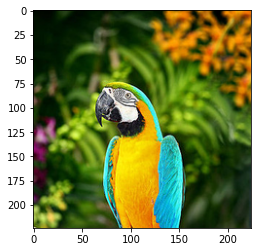

Predicted caption:
 a bird is sitting on a branch in the grass eeee


' a bird is sitting on a branch in the grass eeee'

In [67]:
generate_caption("images/parrot_cropped1.jpg")

Provalo con la foto di una persona (Elon Musk). Nel Tutorial # 07 il modello Inception ha classificato erroneamente questa immagine come una felpa o uno stivale da cowboy.

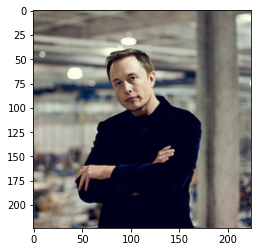

Predicted caption:
 a man in a suit and tie standing in front of a car eeee



In [65]:
generate_caption("images/elon_musk.jpg")

Funzione di aiuto per il caricamento di un'immagine dal set di dati COCO e la stampa delle didascalie reali e della didascalia prevista.

In [72]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

Prova questo su un'immagine del set di addestramento su cui il modello è stato addestrato. In alcuni casi la didascalia generata è effettivamente migliore delle didascalie generate dall'uomo.

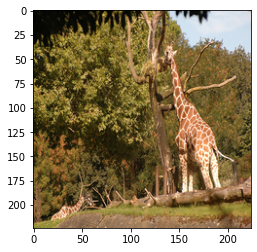

Predicted caption:
 a giraffe standing in a field of tall grass eeee
True captions:
A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


In [69]:
generate_caption_coco(idx=1, train=True)

Ecco un'altra foto di giraffe dal set di addestramento, quindi questa immagine è stata utilizzata anche durante l'allenamento del modello. Ma il modello non può produrre una didascalia accurata. Forse ha bisogno di più formazione o forse un'altra architettura per la Recurrent Neural Network?

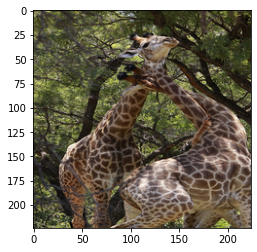

Predicted caption:
 a giraffe standing in a field of grass and trees eeee
True captions:
A couple of giraffe snuggling each other in a forest.
A couple of giraffe standing next to some trees.
Two Zebras seem to be embracing in the wild. 
Two giraffes hang out near trees and nuzzle up to each other.
The two giraffes appear to be hugging each other.


In [70]:
generate_caption_coco(idx=10, train=True)

Ecco un'immagine dal set di convalida che non è stato utilizzato durante l'addestramento del modello. A volte il modello può produrre buone didascalie per immagini che non ha visto durante l'allenamento e a volte no. Puoi fare un modello migliore?

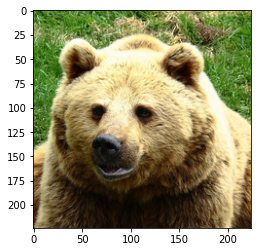

Predicted caption:
 a dog is running with a frisbee in its mouth eeee
True captions:
A big burly grizzly bear is show with grass in the background.
The large brown bear has a black nose.
Closeup of a brown bear sitting in a grassy area.
A large bear that is sitting on grass. 
A close up picture of a brown bear's face.


In [71]:
generate_caption_coco(idx=1, train=False)

## Speech to text
definisco l'algoritmo di speech to tex


In [67]:
import os
import tensorflow as tf 
import os
import speech_recognition as sr
import tensorflow
import numpy 
from numpy import savetxt

In [68]:
def speechToText():
    r = sr.Recognizer()             #Inizializzo il riconoscitore per ascoltare.
    m = sr.Microphone()             #Inizializzo il microfono come fonte per il riconoscitore.

    output_list = list()            #Inizializzo una lista vuota

    string = ""
    
    if(True):
        print("A moment of silence, please...")
        with m as source: r.adjust_for_ambient_noise(source)
        print("Set minimum energy threshold to {}".format(r.energy_threshold))
        for i in range(1):            
            print("Say something!")
            with m as source: audio = r.listen(source)
            print("Got it! Now to recognize it...")
            try:
                # Riconosco il parlato attraverso il metodo recognize_google, che utilizza la tecnologia Google Cloud Speech API
                value = r.recognize_google(audio)

                # Differenzio due casi per scrivere il testo con la codifica corretta
                if str is bytes:                                                # Python 2 usa i byte per le stringhe
                    print(u"You said \"{}\"".format(value).encode("utf-8"))
                    output_list.append(format(value).encode("utf-8"))	    # Colloco nell'ultima posizione della lista la frase appena pronunciata
                else:                                                           # Python 3 usa unicode per le stringhe
                    print("You said {}".format(value))
                    output_list.append(format(value))
            except sr.UnknownValueError:                                        # Eccezione lanciata quando non si riesce a trascrivere l'input
                print("Oops! Didn't catch that")
            except sr.RequestError as e:                                        # Eccezione lanciata quando si hanno problemi con Google Cloud Speech API
                print("Uh oh! Couldn't request results from Google Speech Recognition service; {0}".format(e))

            
        string =format(value)     #Concateno il contenuto della lista, separando le singole frasi con uno spazio. string sara' usato come input per la rete neurale.
        
    return string
        #print('Ho detto questo '+string)
#nuova_lista_output = list()
#nuova_lista_output.append(string)
#print('Ho detto questo NELLA LISTA'+output_list)
#file = open("../output.csv", 'w')   #Ottengo un riferimento al file su cui voglio salvare le recensioni
#savetxt(file,nuova_lista_output, delimiter=';', fmt='%s', newline=".")    #Salvo le recensioni nel file, con il punto invece di \n, altrimenti vado a capo ogni volta che dico una frase





## Conclusione

Questo tutorial ha mostrato come generare didascalie per le immagini. Abbiamo utilizzato un modello di immagine pre-addestrato (VGG16) per generare un "vettore di pensiero" di ciò che l'immagine contiene, e poi abbiamo addestrato una rete neurale ricorrente per mappare questo "vettore di pensiero" a una sequenza di parole.

Funziona abbastanza bene, sebbene sia facile trovare esempi sia nei set di addestramento che in quelli di convalida in cui le didascalie non sono corrette.

È anche importante capire che questo modello non ha una comprensione umana di ciò che contengono le immagini. Se vede l'immagine di una giraffa e produce correttamente una didascalia che lo afferma, non significa che il modello abbia una profonda comprensione di cosa sia una giraffa; la modella non sa che è un animale alto che vive in Africa e negli zoo.

Il modello è semplicemente un modo intelligente per mappare i pixel in un'immagine su un vettore di numeri in virgola mobile che riassumono il contenuto dell'immagine e quindi mappare questi numeri su una sequenza di numeri interi che rappresentano le parole. Quindi il modello è fondamentalmente solo un approssimatore di funzioni molto avanzato piuttosto che un'intelligenza simile a quella umana.

## Compareson

Funzione di confronto. Riceve in input la stringa prodotta dallo speech to tex e quella generata dall'image captioning e da in output una stringa che cintiene le due stringe precedentemente specificate, il nome dell'imaggine, il numero di parole che hanno in comune e la lista di parole on comune divise l'una dall'altra con il simbolo '#\n'.


In [69]:
def compareson( out_speech_to_text, out_image_caption, img):
    
    list = []
    words_common = ""

    #print("Input speech "+out_speech_to_text)
    #print("Input caption "+out_image_caption+"\n")

    x = out_speech_to_text.split()
    y = out_image_caption.split()


    y.remove("eeee") #elimino i ltoken inserito precedentemente "eeee"
    out_image_caption = ' '.join(y)
    
    for i in x: 
        for j in y:
            if i.lower() == j.lower():
                list.append(j.lower())
                i = '$' #una volata effettuato il confronto sostituiso le parole uguali con dei simnoli diversi in modo 
                j = '%' #da non contare più volte le parole ripetute
            
            
    words_common = ' '.join(list)
    number_words_common = len(list)

    #print("numero parole in comune : "+ str(number_words_common))
    #print("Parole in comune : " + words_common)
    
    #se non ci sono parole in comune iserisco un simbolo in questo caso @
    if number_words_common == 0:
        words_common = '@'
    
    string_image = '#\n'.join((img, out_speech_to_text, out_image_caption, str(number_words_common), words_common))

    print('\n'+string_image)    

    return string_image



Inizzializzo una lista vuota dove andrò ad inserire tutte le stringe generate dalla funzione compareson


In [70]:
listOne = [] 

definisco la funzione che prenderà in input il phat dell'immagine e richiamerà al suo interno la funzione di image captioning, la funzione di speech to text e li passerrà alla fuznone di compareson. La stringa che verrà ricavata in output verrà inserita all'interno di una lista.


In [71]:
def analyze_image(img):
    name_img = (os.path.basename(img))
   
    img_caption = generate_caption(img) 
    #print(name_img)
    
    speech_to_text = speechToText()
    #print(speech_to_text)
    
    string = compareson(speech_to_text, img_caption,  name_img)
    
    listOne.append(string)

    

## Gestione del file

Definisco la funzione che salva la lista in un file.

In [72]:
def save_list_img(list, name_file):
    with open(name_file, 'w') as file:
        file.write('\n\n\n'.join(list))


definisco la funzione che prende il contenuto del file

In [73]:
def get_list_img(name_file):
    with open(name_file, 'r') as file:
        content_file = file.read()
    return content_file.split('\n\n\n')


In [80]:
def get_all():
    with open('ImgLandscape.txt', 'r') as file:
        content_file = file.read()
     string_image = '#\n'.join(())
    return x.split('#\n')

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

## ANALISI IMMAGINI PAESAGGISITCHE

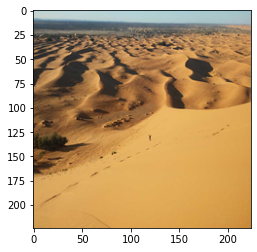

A moment of silence, please...
Set minimum energy threshold to 62.28426297182757
Say something!
Got it! Now to recognize it...
You said desert dunes

deserto1.jpg#
desert dunes#
a herd of sheep standing on top of a green field#
0#
@


In [88]:
analyze_image("D:/Tesi/Paesaggi/deserto1.jpg")

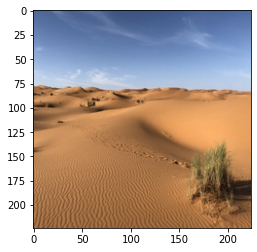

A moment of silence, please...
Set minimum energy threshold to 45.87368072513947
Say something!
Got it! Now to recognize it...
You said huge expanse of sand

deserto2.jpg#
huge expanse of sand#
a man is surfing on a wave in the ocean#
0#
@


In [91]:
analyze_image("D:/Tesi/Paesaggi/deserto2.jpg")

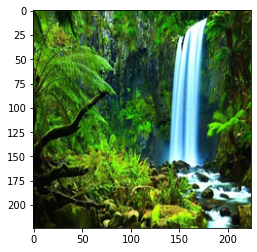

A moment of silence, please...
Set minimum energy threshold to 48.652711883174
Say something!
Got it! Now to recognize it...
You said waterfall in a forest

foresta1.jpg#
waterfall in a forest#
a giraffe is standing in the middle of a grassy area#
2#
in a


In [94]:
analyze_image("D:/Tesi/Paesaggi/foresta1.jpg")

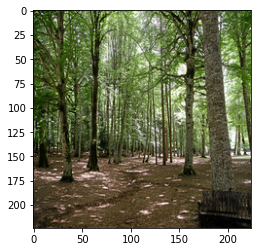

A moment of silence, please...
Set minimum energy threshold to 96.03618429861281
Say something!
Got it! Now to recognize it...
You said wooden bench in the wood

foresta2.jpg#
wooden bench in the wood#
a group of people riding on top of a motorcycle#
0#
@


In [123]:
analyze_image("D:/Tesi/Paesaggi/foresta2.jpg")

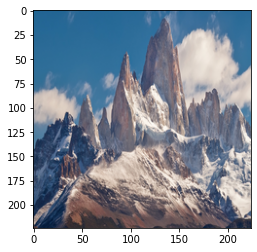

A moment of silence, please...
Set minimum energy threshold to 56.436494025577076
Say something!
Got it! Now to recognize it...
You said mountain range

Montagna1.jpg#
mountain range#
a giraffe standing in a dirt field next to trees#
0#
@


In [125]:
analyze_image("D:/Tesi/Paesaggi/Montagna1.jpg")

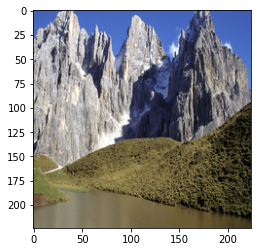

A moment of silence, please...
Set minimum energy threshold to 46.350454506540345
Say something!
Got it! Now to recognize it...
You said river with mountains behind

Montagna2.jpg#
river with mountains behind#
a giraffe standing in a field of tall grass#
0#
@


In [126]:
analyze_image("D:/Tesi/Paesaggi/Montagna2.jpg")

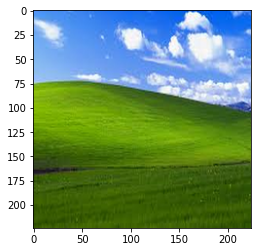

A moment of silence, please...
Set minimum energy threshold to 45.563148078697125
Say something!
Got it! Now to recognize it...
You said expanse of grass

prato1.jpg#
expanse of grass#
a man is flying a kite in a field#
0#
@


In [130]:
analyze_image("D:/Tesi/Paesaggi/prato1.jpg")

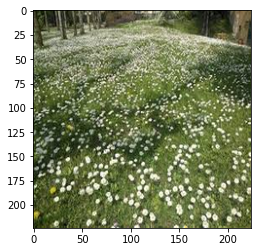

A moment of silence, please...
Set minimum energy threshold to 53.09287067799896
Say something!
Got it! Now to recognize it...
You said filled with the flowers

prato3.jpg#
filled with the flowers#
a herd of sheep standing on top of a grass covered field#
0#
@


In [143]:
analyze_image("D:/Tesi/Paesaggi/prato3.jpg")

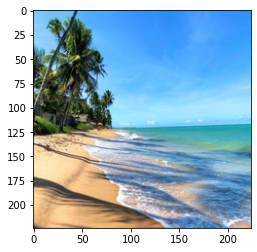

A moment of silence, please...
Set minimum energy threshold to 65.06492122737816
Say something!
Got it! Now to recognize it...
You said beach with trees

spiaggia1.jpg#
beach with trees#
a person riding a snowboard down a snow covered slope#
0#
@


In [154]:
analyze_image("D:/Tesi/Paesaggi/spiaggia1.jpg")

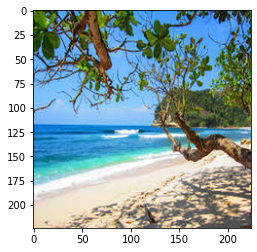

A moment of silence, please...
Set minimum energy threshold to 74.35463336837338
Say something!
Got it! Now to recognize it...
You said beach

spiaggia2.jpg#
beach#
a man riding a skateboard down a street#
0#
@


In [160]:
analyze_image("D:/Tesi/Paesaggi/spiaggia2.jpg")

In [234]:
print(get_list_img('ImgLandscape.txt'))

['deserto1.jpg#\ndesert dunes#\na herd of sheep standing on top of a green field#\n0#\n@', 'deserto2.jpg#\nhuge expanse of sand#\na man is surfing on a wave in the ocean#\n0#\n@', 'foresta1.jpg#\nwaterfall in a forest#\na giraffe is standing in the middle of a grassy area#\n2#\nin a', 'foresta2.jpg#\nwooden bench in the wood#\na group of people riding on top of a motorcycle#\n0#\n@', 'Montagna1.jpg#\nmountain range#\na giraffe standing in a dirt field next to trees#\n0#\n@', 'Montagna2.jpg#\nriver with mountains behind#\na giraffe standing in a field of tall grass#\n0#\n@', 'prato1.jpg#\nexpanse of grass#\na man is flying a kite in a field#\n0#\n@', 'prato3.jpg#\nfilled with the flowers#\na herd of sheep standing on top of a grass covered field#\n0#\n@', 'spiaggia1.jpg#\nbeach with trees#\na person riding a snowboard down a snow covered slope#\n0#\n@', 'spiaggia2.jpg#\nbeach#\na man riding a skateboard down a street#\n0#\n@']


## ANALISI IMMAGINI CHE RITRAGGONO PERSONE

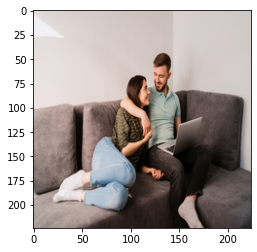

 a man is sitting on a couch with a laptop eeee
A moment of silence, please...
Set minimum energy threshold to 92.90105006340468
Say something!
Got it! Now to recognize it...
You said man and woman sitting on couch

divano.jpg#
man and woman sitting on couch#
a man is sitting on a couch with a laptop#
4#
man sitting on couch


In [123]:
analyze_image("D:/Tesi/persone/divano.jpg")

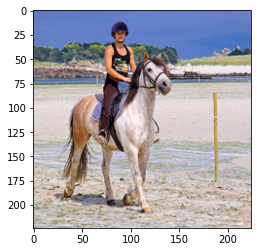

 a man riding a horse on a dirt road eeee
A moment of silence, please...
Set minimum energy threshold to 92.44335155701488
Say something!
Got it! Now to recognize it...
You said girl on horse

cavallo.jpg#
girl on horse#
a man riding a horse on a dirt road#
2#
on horse


In [119]:
analyze_image("D:/Tesi/persone/cavallo.jpg")

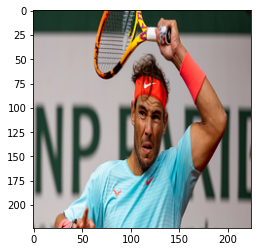

 a man holding a tennis racquet on a tennis court eeee
A moment of silence, please...
Set minimum energy threshold to 74.12173036338922
Say something!
Got it! Now to recognize it...
You said a man holding a tennis racket

nadal.jpg#
a man holding a tennis racket#
a man holding a tennis racquet on a tennis court#
5#
a man holding a tennis


In [132]:
analyze_image("D:/Tesi/persone/nadal.jpg")

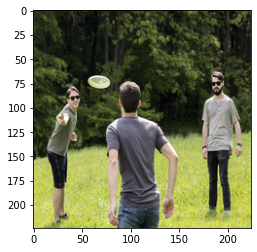

 a group of people standing around a field eeee
A moment of silence, please...
Set minimum energy threshold to 51.14072425108166
Say something!
Got it! Now to recognize it...
You said people in the garden playing a frisbee

frisbee.jpg#
people in the garden playing a frisbee#
a group of people standing around a field#
2#
people a


In [130]:
analyze_image("D:/Tesi/persone/frisbee.jpg")

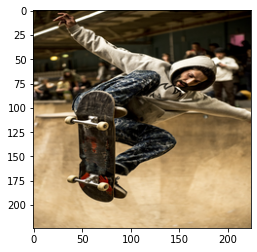

 a man is doing a trick on a skateboard eeee
A moment of silence, please...
Set minimum energy threshold to 63.055959030043745
Say something!
Got it! Now to recognize it...
You said a person jumping on a skateboard

skatebord.jpg#
a person jumping on a skateboard#
a man is doing a trick on a skateboard#
4#
a on a skateboard


In [146]:
analyze_image("D:/Tesi/persone/skatebord.jpg")

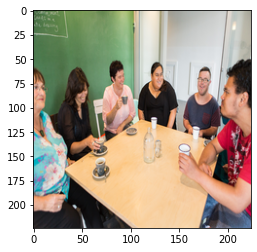

A moment of silence, please...
Set minimum energy threshold to 82.48594538594723
Say something!
Got it! Now to recognize it...
You said people around the table

tavola.jpg#
people around the table#
a group of people sitting around a table with a cake#
3#
people around table


In [168]:
analyze_image("D:/Tesi/persone/tavola.jpg")

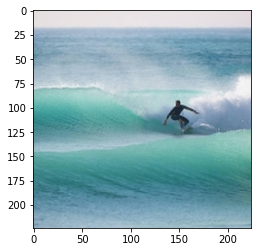

A moment of silence, please...
Set minimum energy threshold to 109.536553194067
Say something!
Got it! Now to recognize it...
You said Surfer art surfing

surf.jpg#
Surfer art surfing#
a surfer riding a wave in the ocean#
1#
surfer


In [185]:
analyze_image("D:/Tesi/persone/surf.jpg")

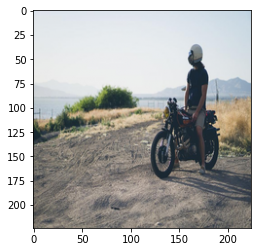

A moment of silence, please...
Set minimum energy threshold to 160.5121266828576
Say something!
Got it! Now to recognize it...
You said a man on the motorcycle

moto.jpg#
a man on the motorcycle#
a man riding a motorcycle down a dirt road#
3#
a man motorcycle


In [192]:
analyze_image("D:/Tesi/persone/moto.jpg")

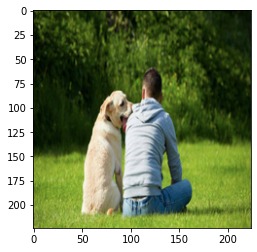

A moment of silence, please...
Set minimum energy threshold to 132.2169152971396
Say something!
Got it! Now to recognize it...
You said a man sitting on the garden with the dog

cane.jpg#
a man sitting on the garden with the dog#
a brown dog laying on a blanket on a field#
3#
a on dog


In [223]:
analyze_image("D:/Tesi/persone/cane.jpg")

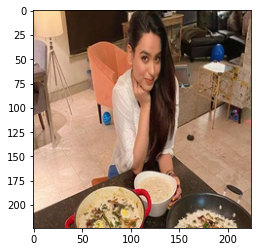

A moment of silence, please...
Set minimum energy threshold to 113.17711399859311
Say something!
Got it! Now to recognize it...
You said woman sitting at a table with the food

ragazza.jpg#
woman sitting at a table with the food#
a man and a woman are sitting at a table#
5#
woman sitting at a table


In [227]:
analyze_image("D:/Tesi/persone/ragazza.jpg")

In [233]:
get_list_img('ImgPeson.txt')

['cavallo.jpg#\ngirl on horse#\na man riding a horse on a dirt road#\n2#\non horse',
 'divano.jpg#\nman and woman sitting on couch#\na man is sitting on a couch with a laptop#\n4#\nman sitting on couch',
 'frisbee.jpg#\npeople in the garden playing a frisbee#\na group of people standing around a field#\n2#\npeople a',
 'nadal.jpg#\na man holding a tennis racket#\na man holding a tennis racquet on a tennis court#\n5#\na man holding a tennis',
 'skatebord.jpg#\na person jumping on a skateboard#\na man is doing a trick on a skateboard#\n4#\na on a skateboard',
 'tavola.jpg#\npeople around the table#\na group of people sitting around a table with a cake#\n3#\npeople around table',
 'surf.jpg#\nSurfer art surfing#\na surfer riding a wave in the ocean#\n1#\nsurfer',
 'moto.jpg#\na man on the motorcycle#\na man riding a motorcycle down a dirt road#\n3#\na man motorcycle',
 'piano.jpg#\na man playing piano#\na man is sitting in a chair with a laptop#\n2#\na man',
 'cane.jpg#\na man sitting on 

## ANALISI IMMAGINI CON FORME GEOMETRICHE

In [76]:
listOne = []

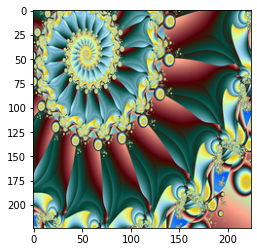

A moment of silence, please...
Set minimum energy threshold to 48.314110914985264
Say something!
Got it! Now to recognize it...
You said a yellow black and green spiral

5.jpg#
a yellow black and green spiral#
a bunch of bananas are stacked together#
1#
a


In [88]:
analyze_image("D:/Tesi/forme/5.jpg")

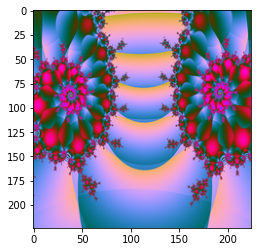

A moment of silence, please...
Set minimum energy threshold to 45.81325595131049
Say something!
Got it! Now to recognize it...
You said two spirals on the margin

6.jpg#
two spirals on the margin#
a vase of flowers sitting on a table#
1#
on


In [118]:
analyze_image("D:/Tesi/forme/6.jpg")

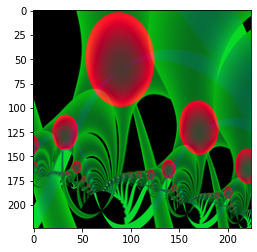

A moment of silence, please...
Set minimum energy threshold to 55.38188109684627
Say something!
Got it! Now to recognize it...
You said red circles and other black and green shapes

7.jpg#
red circles and other black and green shapes#
a close up of a person holding a tennis racket#
0#
@


In [132]:
analyze_image("D:/Tesi/forme/7.jpg")

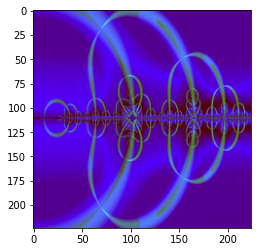

A moment of silence, please...
Set minimum energy threshold to 51.32213195231731
Say something!
Got it! Now to recognize it...
You said overalls

3.jpg#
overalls#
a vase of flowers sitting on a table#
0#
@


In [205]:
analyze_image("D:/Tesi/forme/3.jpg")

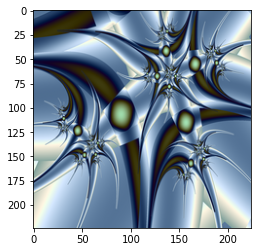

A moment of silence, please...
Set minimum energy threshold to 46.39182449152773
Say something!
Got it! Now to recognize it...
You said stars shapes

1.jpg#
stars shapes#
a clock tower with a clock on each side of it#
0#
@


In [216]:
analyze_image("D:/Tesi/forme/1.jpg")

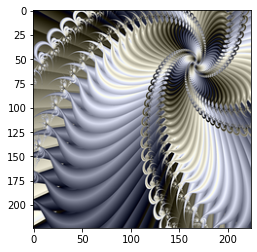

A moment of silence, please...
Set minimum energy threshold to 45.48389573057665
Say something!
Got it! Now to recognize it...
You said grey and white Vortex

2.jpg#
grey and white Vortex#
a zebra standing in a field of grass#
0#
@


In [222]:
analyze_image("D:/Tesi/forme/2.jpg")

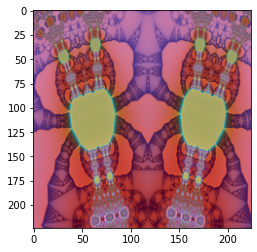

A moment of silence, please...
Set minimum energy threshold to 48.51691585287481
Say something!
Got it! Now to recognize it...
You said fractal image

8.jpg#
fractal image#
a bunch of bananas are stacked together#
0#
@


In [229]:
analyze_image("D:/Tesi/forme/8.jpg")

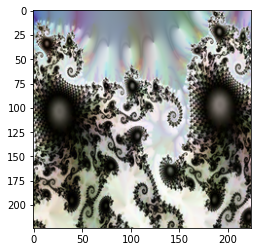

A moment of silence, please...
Set minimum energy threshold to 49.275446277778805
Say something!
Got it! Now to recognize it...
You said fractal shape

9.jpg#
fractal shape#
a large white vase with flowers in it#
0#
@


In [231]:
analyze_image("D:/Tesi/forme/9.jpg")

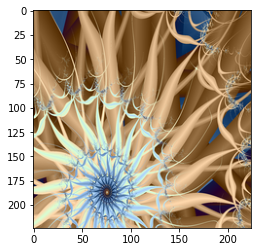

A moment of silence, please...
Set minimum energy threshold to 46.05579927373308
Say something!
Got it! Now to recognize it...
You said blue spirit with waves

4.jpg#
blue spirit with waves#
a vase of flowers sitting on a table#
0#
@


In [233]:
analyze_image("D:/Tesi/forme/4.jpg")

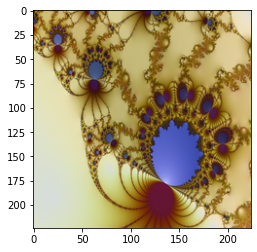

A moment of silence, please...
Set minimum energy threshold to 46.73893431588891
Say something!
Got it! Now to recognize it...
You said indefinite forms

10.jpg#
indefinite forms#
a vase of flowers sitting on a table#
0#
@


In [235]:
analyze_image("D:/Tesi/forme/10.jpg")

In [236]:
print(listOne)

['5.jpg#\na yellow black and green spiral#\na bunch of bananas are stacked together#\n1#\na', '6.jpg#\ntwo spirals on the margin#\na vase of flowers sitting on a table#\n1#\non', '7.jpg#\nred circles and other black and green shapes#\na close up of a person holding a tennis racket#\n0#\n@', '3.jpg#\novals#\na vase of flowers sitting on a table#\n0#\n@', '1.jpg#\nstars shapes#\na clock tower with a clock on each side of it#\n0#\n@', '2.jpg#\ngrey and white Vortex#\na zebra standing in a field of grass#\n0#\n@', '8.jpg#\nfractal image#\na bunch of bananas are stacked together#\n0#\n@', '9.jpg#\nfractal shape#\na large white vase with flowers in it#\n0#\n@', '4.jpg#\nblue spirit with waves#\na vase of flowers sitting on a table#\n0#\n@', '10.jpg#\nindefinite forms#\na vase of flowers sitting on a table#\n0#\n@']


In [226]:
del listOne[-1]
print(listOne)

['5.jpg#\na yellow black and green spiral#\na bunch of bananas are stacked together#\n1#\na', '6.jpg#\ntwo spirals on the margin#\na vase of flowers sitting on a table#\n1#\non', '7.jpg#\nred circles and other black and green shapes#\na close up of a person holding a tennis racket#\n0#\n@', '3.jpg#\novals#\na vase of flowers sitting on a table#\n0#\n@', '1.jpg#\nstars shapes#\na clock tower with a clock on each side of it#\n0#\n@', '2.jpg#\ngrey and white Vortex#\na zebra standing in a field of grass#\n0#\n@']


In [237]:
save_list_img(listOne, 'ImgGeometric.txt')